In [7]:
# <!-- collapse=True -->
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Shape from focus

Avez-vous déjà observé une fourmi au microscope ? Le problème est que la profondeur de champ d'un microscope est en général assez faible, limitant la possibilité d'observer un objet en 3d. Seule une faible portion de l'image est alors nette. En revanche, le réglage du focus est souvent très fin.  Il est donc possible de scanner verticalement l'objet et d'observer successivement les zones nettes de l'objet, correspondant à différentes altitudes. 

L'idée est de prendre une série de photos correspondant à des hauteur différentes pour ensuite les combiner numériquement et ainsi augmenter la profondeur de champ de l'image finale.

_Remarque:_ C'est une technique existante et déjà étudiée. Il existe plusieurs articles concernant ce sujet ([google scholar](https://scholar.google.fr/scholar?q=%22shape+from+focus%22)).

J'ai voulu tester cette idée sur une fleur, étant donné qu'il est plus difficile d'attraper une fourmi.

Avec un peu de patience on obtient un cube d'une vingtaine d'images correspondant à différente coupe de l'objet. La taille de la fleur est inférieure au millimètre. 

Comment évaluer numériquement les zones nettes à l'intérieur de chaque image, afin de constituer une seule image finale entièrement nette? Cette mesure est obtenue en évaluant la dérivée seconde (Laplacien en 2d) des valeurs de gris de l'image. Une zone nette presente des variations rapides, donc des courbures importantes, alors qu'une zone floue est lisse, avec des courbures faibles.

On utilise la librairie `ndimage` de Scipy ([doc](https://docs.scipy.org/doc/scipy-0.18.1/reference/ndimage.html)).

In [8]:
from scipy import ndimage

## Chargement des photos

In [9]:
n = 20 # nombre de photos

images = []
for i in range(1, n+1):
    filename = './data_shapefromfocus/'+'focus%02d.jpg'%i
    images.append( ndimage.imread(filename) ) #, flatten=True

Exemple de 3 images succesives: (voir aussi l'{attach}[image n°5](/physique/data_shapefromfocus/focus05.jpg))

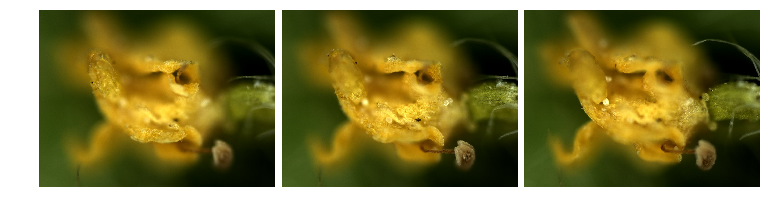

In [10]:
# <!-- collapse=True -->
fig, ax = plt.subplots( 1, 3 , figsize=(10, 6));
for i in range(3):
    k = 3 + i
    ax[i].imshow( images[k] )
    ax[i].set_adjustable('box')
    ax[i].axis('off')#_off()
    
plt.subplots_adjust(wspace=0.03, hspace=.02 , top=1, bottom=0, left=0, right=1);

On travail sur les valeurs de gris seulement. La fonction suivante permet de convertir les valeurs RGB en scalaire.

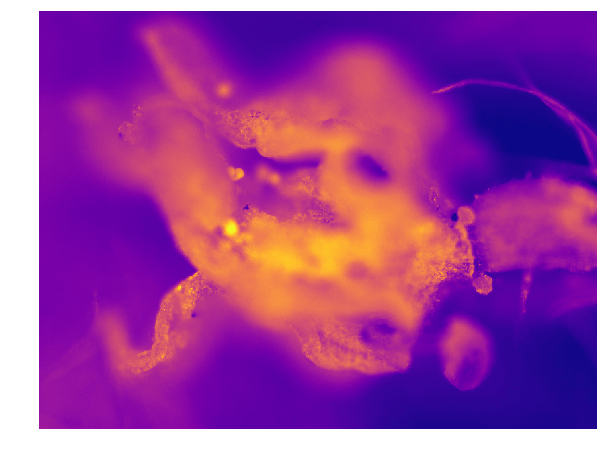

In [13]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
plt.figure( figsize=(10, 12) );
plt.imshow( rgb2gray( images[6] ), cmap=plt.cm.plasma);
plt.axis('off');

On souhaite évaluer le degrée de netteté de chaque pixels. Pour cela l'idée est de calculer la dérivée seconde (le Laplacien) en chaque point des images. Le filtre `gaussian_laplace(I, sigma)` permet de réaliser cela ([doc](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.ndimage.gaussian_laplace.html#scipy.ndimage.gaussian_laplace)). Comme la courbure peut être négative ou positive on calcul le carré du laplacien.

Le paramètre important est la largeur du filtre $\sigma$. On le trouve par essais-erreur.

In [136]:
sigma = 4
laplaciens = []
for I in images:
    Igray = rgb2gray( I )
    curv = ndimage.filters.gaussian_laplace( Igray , sigma)
    curv2 = curv**2 
    laplaciens.append( curv2  )

### Effet du filtre 

En appliquant le filtre à une image ayant un unique pixel "noir"  (=1), on obtient la fonction du filtre. L'application du filtre consiste au produit de convolution de cette fonction avec l'image. La courbe suivante est le profil passant par le centre.

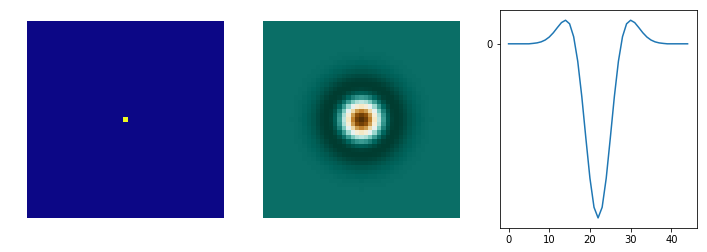

In [137]:
# <!-- collapse=True -->
nd = 45
dirac = np.zeros( (nd, nd) )
dirac[ int(nd/2), int(nd/2)  ] = 1

fig, ax = plt.subplots( 1, 3 , figsize=(12, 4));

F_dirac = ndimage.filters.gaussian_laplace( dirac , sigma) 
ax[0].imshow(  dirac , cmap=plt.cm.plasma ); ax[0].axis('off');
ax[1].imshow(  F_dirac, cmap=plt.cm.BrBG );
ax[1].axis('off');

ax[2].plot(  F_dirac[int(nd/2), :], '-'); ax[2].set_yticks([0]); ax[2].set_yticklabels(['0']); 

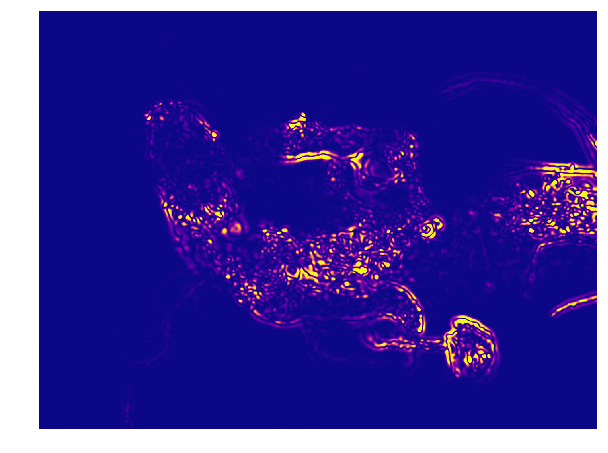

In [138]:
plt.figure( figsize=(10, 12) );
plt.imshow(  laplaciens[4], cmap=plt.cm.plasma, vmin=0, vmax=1 );
plt.axis('off');

## Profils transverses

In [139]:
Lx, Ly, nColors = np.shape( images[0] )
points = [ (np.random.randint(Lx), np.random.randint(Ly)) for i in range(20) ]

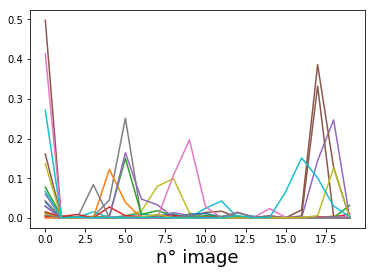

In [140]:
for pixel in points:
    profil = [ L[pixel] for L in laplaciens]

    plt.plot( profil ); plt.xlabel('n° image');

on cherche ensuite l'argument, c'est-à-dire l'indice, du maximum pour chaque pixel.

In [141]:
cArgMax = np.argmax(  np.array(laplaciens), 0 )

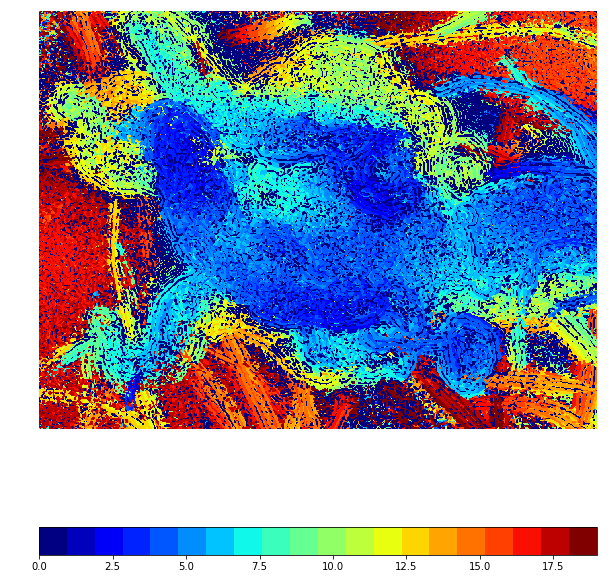

In [142]:
plt.figure( figsize=(10, 12) );
cmap = plt.get_cmap('jet', len(images));
cax = plt.imshow( cArgMax, cmap=cmap);
plt.colorbar(cax, orientation='horizontal')
plt.axis('off');

On filtre ensuite par la mediane. Là encore la taille du filtre est ajustée par essais.

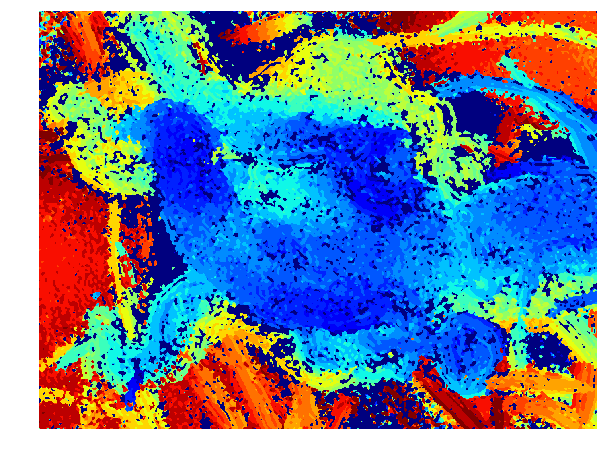

In [145]:
n = 8
cMax = ndimage.filters.median_filter(cArgMax, footprint=np.ones((n, n)) )
cMax = np.round( cMax )

plt.figure( figsize=(10, 12) );
plt.imshow( cMax, cmap=cmap);
plt.axis('off');

Puis on forme une image unique en choisiant le pixel le plus nette dans chaque image:

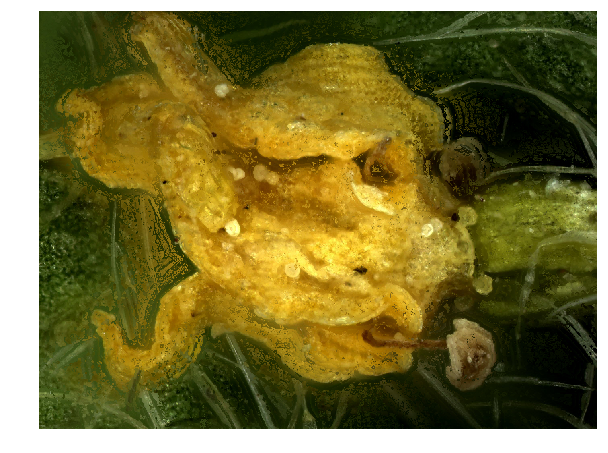

In [146]:
I_merged = images[0]
for k, I in enumerate( images ):
    I_merged[ cMax==k ] = images[k][ cMax==k ]

plt.figure( figsize=(10, 12) );
plt.imshow( I_merged );
plt.axis('off');

Le **microscope électronique à balayage** est quand même beaucoup mieux pour faire des photos de fourmis: https://commons.wikimedia.org/wiki/File:Ant_with_gear.jpg